# Backtest a  Strategy

In [6]:
%matplotlib inline
from smartbots.stats import return_series
# extend pandas functionality with metrics, etc.
from smartbots.historical_downloader import historical_downloader
import datetime as dt
import pandas as pd
from smartbots.engine.data_reader import read_data_to_dataframe
from smartbots.engine.portfolio_constructor import Portfolio_Constructor

CCXT Version: 1.95.36


## Parameters

In [7]:
asset_type = 'financial' # financial , crypto
fresh_start = True # if you want to download the symbols again
download_data = False # True for downloading
start_date = dt.datetime(2022,10,1) # Start date of data to download
end_date = dt.datetime.utcnow() # End date of data to download
# Portfolio construction
inicial_cash = 50000 # initial capital for the portfolio
base_currency = 'USD'
if asset_type == 'crypto':
    interval = '1h'  # 1m , 5m, 30m, 1h
    provider = 'kucoin'  # test , binance, coinbase ...
    symbols = ["BTC-USDT","ETH-USDT"] # List of symbols to download from provider
    benchmark = "BTC-USDT"
elif asset_type == 'financial':
    interval = '1min'  # 1min , 5min, 30mi
    provider = 'darwinex'  #
    symbols = ["AUDNZD","EURJPY"] # List of symbols to download from provider
    benchmark = "SPY"




## 1) Download Historical Data from Data Provider and save into the database.
Please see here the docs for crypto of the exchanges available: https://github.com/ccxt/ccxt/wiki/Manual#markets


If you already have the data in a database, you can skip this step and go to the next.

Dependings of the symbols and the length of the data, the data loader will take some time to complete. Be pacience.

If there are already some data in the database, it will update only the new data.


In [8]:
if download_data:
    clean_symbols_database = []
    if fresh_start:
        clean_symbols_database = symbols
     # Interval of data to download,
    historical_downloader(symbols=symbols,start_date=start_date, end_date=dt.datetime.utcnow(),
                          provider=provider,clean_symbols_database=clean_symbols_database,interval=interval)

## 2) Read Historical Data from Database and Visualize it.


In [9]:

df1 = read_data_to_dataframe(symbols[0], provider,start_date=start_date,end_date=end_date, interval=interval)
df2 = read_data_to_dataframe(symbols[-1], provider,start_date=start_date,end_date=end_date,interval=interval)

df = pd.concat([df1,df2],axis=0)

<AxesSubplot:xlabel='date'>

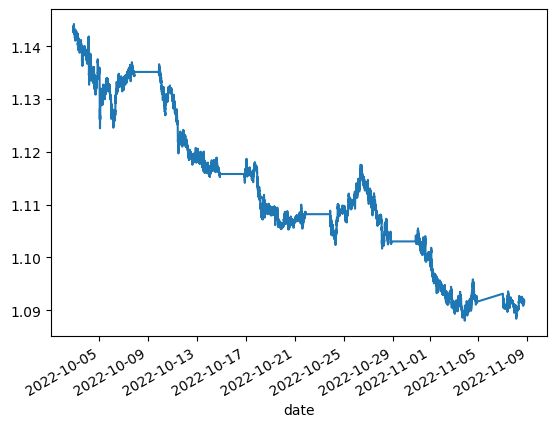

In [10]:
df1.close.plot()

## 3) BackTesting

### Settings of the strategy

In [11]:


strategy1 = {'id': 1, # unique id for strategy to run
             'strategy': 'Simple_Avg_Cross', # strategy name, create in smartbots/crypto/strategies
             'params': {'ticker': 'AUDNZD',
             'short_period': 10,
             'long_period': 500,
             'quantity': 1,
             'limit_save_values':1000,'point_value':100000,'slippage':0, 'base_currency':{'ticker':base_currency+'NZD',
                                                                                          'value':1.7}}}

strategy2 = {'id': 2, # unique id for strategy to run
             'strategy': 'Simple_Avg_Cross', # strategy name, create in smartbots/crypto/strategies
             'params': {'ticker': 'EURJPY',
             'short_period': 10,
             'long_period': 500,
             'quantity': 1,
             'limit_save_values':1000,'point_value':100000,'slippage':0, 'base_currency':{'ticker':base_currency+'JPY',
                                                                                          'value':145}}}



conf_portfolio = {'Name': 'PortfolioExample1',
                  'Data_Sources': 
                  [{'tickers': symbols,
                   'event_type': 'bar',
                   'historical_source': 'mongoDB',
                   'historical_library': f'{provider}_historical_{interval}'}],
                   'Strategies': 
                    [strategy1, strategy2]}

In [12]:
# baskteting the strategies
portfolio = Portfolio_Constructor(conf_portfolio, run_real=False, asset_type=asset_type,
                                  send_orders_to_broker=False, start_date=start_date,
                                  inicial_cash=inicial_cash)
portfolio.run_simulation() # backtest 

info_port = portfolio.get_saved_values_strategy() # read change of positions

Loading AUDNZD from 2022-10-01 00:00:00
Loading EURJPY from 2022-10-01 00:00:00
Loading AUDNZD from 2022-11-01 00:00:00
Loading EURJPY from 2022-11-01 00:00:00


## Statistics

Plots and statistics of the Strategies and the Portfolio.

<AxesSubplot:xlabel='datetime'>

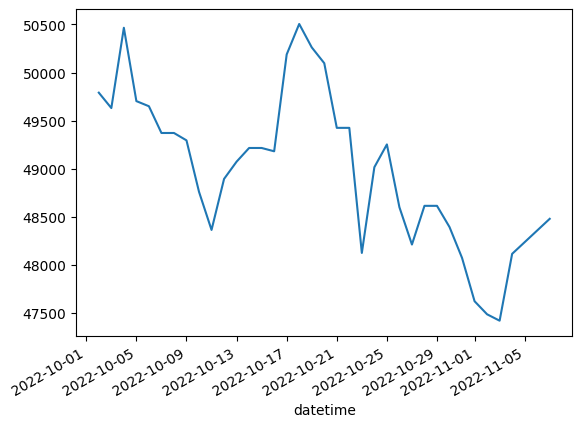

In [13]:
equities =portfolio.equity_handler.get_equities()
equity_portfolio = equities['equity_portfolio']['equity']
metrics =return_series.from_nav(equity_portfolio)
equity_portfolio.plot()

In [14]:
metrics.summary()

Performance number
Return                                      -2.63308
# Events                                          35
# Events per year                                345
Annua Return                                -26.2924
Annua Volatility                             18.4025
Annua Sharpe Ratio (r_f = 0)                -1.42875
Max Drawdown                                 6.10614
Max % return                                 2.04633
Min % return                                -2.63013
MTD                                         0.845159
YTD                                         -2.63308
Current Nav                                  48479.9
Max Nav                                      50504.8
Current Drawdown                             4.00946
Calmar Ratio (3Y)                           -4.30591
# Positive Events                                 16
# Negative Events                                 19
Value at Risk (alpha = 95)                   1.51041
Conditional Value at Risk (